## ToDo
- plot probabilities for each proto for each chemical on ptable -- like a heatmap

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
import random
# import graphviz
import scipy
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sympy import *
from IPython.display import display, Math
import os
pd.set_option('display.max_columns', None)
from datetime import datetime
import json
import time
import glob

#Dictionary for functions in gplearn
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'exp': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}


def calc_weights(binary_labels):
    """Returns weights to produce 50-50 class weighting
    """
    n_pos = np.sum(binary_labels)
    n_neg = len(binary_labels) - n_pos
    weights = [1 if label==1 else n_pos/n_neg for label in binary_labels]
    return weights
    

def reduce_feat_by_corr(feat_df, thresh=0.95):
    """
    Returns a copy of the input dataframe with correlated 
    features removed (defined as correlation > thresh)

    Parameters:
    feat_df (pandas.DataFrame): Dataframe containing the features
    thresh (float): Correlation threshold value

    Returns:
    pandas.DataFrame: A copy of the input dataframe with pruned features
    """
    feats_to_prune = set([])
    immune = set([])
    corr = feat_df.corr()
    for feat in feat_df.columns:
        # If we already pruned this feature, we're done here
        if feat in feats_to_prune: continue
        # If not, make it immune and discard things correlated with it
        immune.update({feat})
        correlated_features = set(corr[corr[feat] > thresh].index)
        feats_to_prune.update(correlated_features - immune)
    return feat_df.drop(columns=feats_to_prune).copy()


def calc_feature_importances(feat_df, label_df, seed, n_splits=5):
    
    ### Store results
    cv_precisions = []
    cv_recalls = []
    aggregated_feature_importances = []
    
    features = feat_df.to_numpy()
    labels = label_df.label_binary.to_numpy()
    
    ### K-fold CV
    skf = StratifiedKFold(n_splits=n_splits)
    for i, (train_idx, test_idx) in enumerate(skf.split(feat_df,label_df.label_binary)):
        feat_df_train = feat_df.iloc[train_idx]
        feat_df_test =  feat_df.iloc[test_idx]
        label_df_train = label_df.iloc[train_idx]
        label_df_test =  label_df.iloc[test_idx]
        # Fit, eval naive rf model
        clf = RandomForestClassifier(n_estimators=50, class_weight='balanced', criterion='log_loss', 
                                     random_state=seed, ccp_alpha=0.001, n_jobs=-1)
        clf.fit(feat_df_train.to_numpy(), 
                label_df_train.label_binary.to_numpy())
        predict_labels = clf.predict(feat_df_test.to_numpy())
        precision = precision_score(label_df_test.label_binary.to_numpy(), predict_labels)
        recall = recall_score(label_df_test.label_binary.to_numpy(), predict_labels)
        # Record results
        aggregated_feature_importances.append(clf.feature_importances_)
        cv_precisions.append(precision)
        cv_recalls.append(recall)
        # print(f'Mean depth:      {np.mean([estimator.get_depth() for estimator in clf.estimators_])}')
        # print(f'Mean node count: {np.mean([estimator.tree_.node_count for estimator in clf.estimators_])}')
        # print(f'OOB score:       {clf.oob_score_}')
    return np.mean(aggregated_feature_importances, axis=0), np.mean(cv_precisions), np.mean(cv_recalls)


def reduce_feat_by_RFimport(feat_df, label_df, seed, n_features=5, keep_frac=0.75):
    feature_names = list(feat_df.columns)
    nfeats, precs, recalls = [], [], []
    
    while True:
        ### Calculate importances
        importances, prec, recall = calc_feature_importances(feat_df[feature_names], label_df, seed)
        
        ### Record results
        nfeats.append(len(importances))
        precs.append(prec)
        recalls.append(recall)
        
        ### Terminal case: cut to n_features, evaluate one more time
        if len(importances) < np.ceil(n_features/keep_frac):
            feature_names = feature_names[:n_features]
            importances, prec, recall = calc_feature_importances(feat_df, label_df, seed)
            nfeats.append(len(importances))
            precs.append(prec)
            recalls.append(recall)
            return feature_names[:n_features], nfeats, precs, recalls
        
        ### Iterative case: keep top keep_frac of features, discard the rest
        _, feature_names = zip(*sorted(zip(importances, feature_names), reverse=True))
        feature_names = list(feature_names)
        feature_names = feature_names[:int(np.ceil(keep_frac*len(feature_names)))]
        # print(f'{len(importances)} features left')


def prep_labels(label_df):
    ### Prepare labels
    # Find unique labels and counts
    class_df = pd.DataFrame(label_df.value_counts()).reset_index()
    class_df = class_df.rename(columns={0:'population'})
    class_df['label'] = class_df.index
    # Convert to numerical labels
    proto2label = {proto:label for proto,label in class_df[['Prototype','label']].to_numpy()}
    label2proto = {label:proto for proto,label in class_df[['Prototype','label']].to_numpy()}
    label_df['label'] = [proto2label[proto] for proto in label_df.Prototype]
    return label_df, class_df, proto2label, label2proto



def vis_expr(classifier, save_prefix):
    """Function for prettifying expressions output by the symbolic classifier
    Converts program expression -> sympy -> latex -> janky matplotlib workaround for latex formulas
    """
    expression = latex(sympify((str(classifier._program)), locals=converter))
    fig, ax = plt.subplots(figsize=(0.1,0.1))
    ax.set_xticks([]); ax.set_yticks([])
    ax.axis('off')
    plt.text(0, 0,'$%s$'%expression, size=15)
    plt.savefig(f'{save_prefix}_expression.png', dpi=300, bbox_inches='tight')
    plt.show()


def save_results(search, save_prefix):
    # Save formula of best estimator
    classifier = search.best_estimator_
    formula = str(classifier._program)
    with open(f'{save_prefix}_formula.txt', 'a+') as f:
        f.write(formula)
    # Save params of best estimator
    params = classifier.get_params()
    params['feature_names'] = list(params['feature_names'])
    params['function_set'] = list(params['function_set'])
    with open(f'{save_prefix}_params.json', 'a+') as f:
        json.dump(params, f)
    # Save hyperparam opt results  
    pd.DataFrame(search.cv_results_).to_json(f'{save_prefix}_cvresults.json')      

        
def plot_run(classifier, save_prefix):
    run_details = classifier.run_details_
    fig, ax1 = plt.subplots(figsize=(6,2))
    skip_gen = 1
    colors = ['tab:red', 'tab:blue']
    ### Plot lengths
    ax1.set_ylabel('Length', color=colors[0])
    ax1.plot(run_details['generation'][skip_gen:], run_details['average_length'][skip_gen:], 
             label='Avg Length', color=colors[0])
    ax1.plot(run_details['generation'][skip_gen:], run_details['best_length'][skip_gen:], 
             label='Best Length', color=colors[0], linestyle='--')
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ### Plot fitnesses
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('average_fitness', color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(run_details['generation'][skip_gen:], run_details['average_fitness'][skip_gen:], 
             label='Avg Fitness', color=colors[1])
    ax2.plot(run_details['generation'][skip_gen:], run_details['best_fitness'][skip_gen:], 
             label='Best Fitness', color=colors[1], linestyle='--')
    ax2.tick_params(axis='y', labelcolor=colors[1])
    ###
    ax1.set_xlabel('Generation')
    plt.xlim(0,None)
    plt.legend()
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(f'{save_prefix}_training_details.png', dpi=400, bbox_inches='tight')
    plt.show()


def examine_search(search, features_test, labels_test, select_prototype, fold, seed, proto2label):
    """
    Examines the results of hyperparam search. It includes plotting the run 
    history, evaluating the classifier, and recording the best classifier
    details and hyperparam search details.

    :param search: (sklearn GridSearchCV or RandomizedSearchCV) The search 
        object being examined
    :param features_test: (numpy array) The test dataset features
    :param labels_test: (numpy array) The test dataset labels
    :param select_prototype: (str) The prototype given positive label (1vsall)
    :param fold: (int) The fold number
    :param seed: (int) The random seed used
    :param proto2label: (dict) The prototype to label mapping
    """
    ### Plot run history
    classifier = search.best_estimator_
    
    ### Evaluate on test set
    predictions = classifier.predict(features_test)
    precision = int(100*precision_score(labels_test, predictions))
    recall = int(100*recall_score(labels_test, predictions))
    roc_auc = int(100*roc_auc_score(labels_test,predictions)) 
    print(f'AUC:    \t{roc_auc}\nPrecision: \t{precision}\nRecall: \t{recall}')
    
    ### Visualize expression, record run
    dt_string = datetime.now().strftime("%Y%m%d_%H%M")
    save_prefix = f'models/c{proto2label[select_prototype]}vsall_{select_prototype}_seed{seed}_fold{fold}_auc{roc_auc}_prec{precision}_reca{recall}_len{classifier._program.length_}_{dt_string}'
    vis_expr(classifier, save_prefix)
    save_results(search, save_prefix)
    plot_run(classifier, save_prefix)

    
    
def train_test_save(feat_df, label_df, select_prototype, seed=0, n_splits=5):
    
    ### Convert to binary (1 vs rest), where 1 => select_prototype
    label_df['label_binary'] = (label_df.Prototype == select_prototype).astype(int)
    
    ### Bootstrap to get balance
    pos_idxs = label_df[label_df.label_binary == 1].index
    mult_factor = int(len(label_df[label_df.label_binary == 0])/len(pos_idxs))
    print(f'Copying positive labels {mult_factor}x to achieve balance')
    pos_feat_df = feat_df.iloc[pos_idxs]
    pos_label_df = label_df.iloc[pos_idxs]
    feat_df = pd.concat([pos_feat_df]*(mult_factor - 1) + [feat_df]).reset_index(drop=True)
    label_df = pd.concat([pos_label_df]*(mult_factor - 1) + [label_df]).reset_index(drop=True)
    
    ### Calculate weights label_weights
    label_df['weight'] = calc_weights(label_df.label_binary)
    
    ### Train-test split
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed) 
    for i, (train_idx, test_idx) in enumerate(skf.split(feat_df, label_df.label_binary)):
        start = time.time()
        
        feat_df_train = feat_df.iloc[train_idx]#.copy()
        feat_df_test =  feat_df.iloc[test_idx]#.copy()
        label_df_train = label_df.iloc[train_idx]#.copy()
        label_df_test =  label_df.iloc[test_idx]#.copy()
        print(f"Fold {i}:")
    
        ### RF Feature reduction
        features_to_keep, n, precs, recs = reduce_feat_by_RFimport(feat_df, label_df, seed)
        feat_df_train = feat_df_train[features_to_keep]
        feat_df_test = feat_df_test[features_to_keep]
        print(f'Reduced feature set: {list(feat_df_train.columns)}')

        
        ### Train, eval model
        param_distros = {'population_size': scipy.stats.randint(500,2000),
                         'tournament_size': scipy.stats.randint(10,50),
                         # 'generations': scipy.stats.randint(10,50),
                         # 'parsimony_coefficient': scipy.stats.uniform(0.01, 0.001)
                     }
        
        base_estimator = SymbolicClassifier(init_depth=(1,5),
                                            parsimony_coefficient=0.01,
                                            generations=40,
                                            p_crossover = 0.85,
                                            p_subtree_mutation = 0.01,
                                            p_point_mutation = 0.01,
                                            p_hoist_mutation = 0.1,
                                            const_range=(-10,10),
                                            feature_names=list(feat_df_train.columns),
                                            # verbose=1,
                                            n_jobs=-1, 
                                            random_state=0,
                                            function_set={'add','sub','mul','div','max','min'},
                                            warm_start=(i>0)
                                            )
        sh = HalvingRandomSearchCV(base_estimator, param_distros, cv=5,
                                   min_resources=20, max_resources=80, factor=2
                                  ).fit(feat_df_train.to_numpy(), label_df_train.label_binary)
        ### Evaluate, record model
        examine_search(sh, feat_df_test.to_numpy(), label_df_test.label_binary, 
                       select_prototype, fold=i, seed=seed, proto2label=proto2label)
        
        print(f'Time elapsed: {np.round((time.time()-start)/60,1)}m')

# train_test_save(feat_df, label_df, 'Rutile#TiO2')

# Import Data

In [2]:
### CONSTANTS ###########################################################
label_path = '../3_generate_features/final_label_array.csv'
feat_path = '../3_generate_features/dimensionless_cropped_final_feature_array.csv'
#########################################################################

label_df = pd.read_csv(label_path).drop(columns='Unnamed: 0',errors='ignore')
feat_df = pd.read_csv(feat_path).drop(columns='Unnamed: 0',errors='ignore')

# Preprocess Data

In [3]:
### Prep, find most populous prototypes
label_df, class_df, proto2label, label2_proto = prep_labels(label_df)
display(class_df.head(10))

### Initial feature reduction
print(f'{len(feat_df.columns)} features before pruning.')
feat_df = reduce_feat_by_corr(feat_df)
print(f'{len(feat_df.columns)} features after removing correlated features.')
# display(feat_df.columns)

,Prototype,population,label
0,Laves(cub)#MgCu2,1532,0
1,Fluorite#CaF2,507,1
2,Laves(2H)#MgZn2,475,2
3,Rutile#TiO2,467,3
4,AlB2,368,4
5,Pyrite#FeS2(cP12),250,5
6,CuAl2,237,6
7,CdI2(hP3),203,7
8,CaC2-I(I4/mmm),182,8
9,Marcasite#FeS2(oP6),169,9


1043 features before pruning.
509 features after removing correlated features.


In [ ]:
### Loop through 20 most populous classes
for proto in class_df.head(20).Prototype:
    
    ### Train, test, save
    print(proto)
    train_test_save(feat_df, label_df, proto)

Laves(cub)#MgCu2
Copying positive labels 4x to achieve balance
Fold 0:
Reduced feature set: ['(e1_Column+e2_Row)/e1_Column', 'e1_Column/e2_Row', '(e2_NpValence+e2_NUnfilled)/e2_NpValence', '(e1_Column-e2_Row)/e1_Column', '(e1_MeltingT+e2_MeltingT)/e1_MeltingT']


### Testing

In [57]:
### Bootstrap to get balance
pos_idxs = label_df[label_df.label_binary == 1].index
mult_factor = int(len(label_df[label_df.label_binary == 0])/len(pos_idxs))
print(mult_factor)
pos_feat_df = feat_df.iloc[pos_idxs]
pos_label_df = label_df.iloc[pos_idxs]
aug_feat_df = pd.concat([pos_feat_df]*(mult_factor - 1) + [feat_df]).reset_index(drop=True)
aug_label_df = pd.concat([pos_label_df]*(mult_factor - 1) + [label_df]).reset_index(drop=True)
print(np.unique(aug_label_df.label_binary, return_counts=True))

17
(array([0, 1]), array([8281, 7939]))


In [59]:
### Run a test of SymClass 
this_feat_df = aug_feat_df
this_label_df = aug_label_df
skf = sklearn.model_selection.check_cv(5, y=this_label_df.label_binary.to_numpy(),
                                 classifier=sklearn.base.is_classifier(sh.estimator))
for i, (train_idx, test_idx) in enumerate(skf.split(this_feat_df, this_label_df.label_binary)):
    print(i)
    features_train = this_feat_df.iloc[train_idx].to_numpy()
    features_test = this_feat_df.iloc[test_idx].to_numpy()

    labels_train = this_label_df.iloc[train_idx].label_binary
    labels_test = this_label_df.iloc[test_idx].label_binary

    classifier = base_estimator
    classifier.fit(features_train, labels_train)#, this_label_df.iloc[train_idx].weight)
    predictions = classifier.predict(features_test)
    precision = int(100*precision_score(labels_test, predictions))
    recall = int(100*recall_score(labels_test, predictions))
    roc_auc = int(100*roc_auc_score(labels_test,predictions)) 
    print(f'AUC:    \t{roc_auc}\nPrecision: \t{precision}\nRecall: \t{recall}')

0
AUC:    	88
Precision: 	80
Recall: 	99
1
AUC:    	86
Precision: 	79
Recall: 	97
2
AUC:    	87
Precision: 	79
Recall: 	99
3
AUC:    	87
Precision: 	80
Recall: 	99
4
AUC:    	89
Precision: 	83
Recall: 	97


In [22]:
np.unique(label_df.label_binary.to_numpy(), return_counts=True)

(array([0, 1]), array([8281,  467]))

In [61]:
param_distros = {'population_size': scipy.stats.randint(500,2000),
                 'tournament_size': scipy.stats.randint(10,50),
                 'generations': scipy.stats.randint(10,50),
#                  'parsimony_coefficient': scipy.stats.uniform(0.01, 0.001)
             }
feature_names = list(feat_df.columns)
base_estimator = SymbolicClassifier(init_depth=(1,5),
                                    parsimony_coefficient=0.005,
                                    generations=25,
                                    p_crossover = 0.85,
                                    p_subtree_mutation = 0.01,
                                    p_point_mutation = 0.01,
                                    p_hoist_mutation = 0.1,
                                    const_range=(-10,10),
                                    feature_names=feature_names,
                                    # verbose=1,
                                    n_jobs=-1, 
                                    random_state=0,
                                    function_set={'add','sub','mul','div','max','min'},
                                    )

start = time.time()
sh = HalvingRandomSearchCV(base_estimator, param_distros, cv=5,
                           min_resources=20, max_resources=40, factor=2, error_score='raise'
                            ).fit(aug_feat_df.to_numpy(), aug_label_df.label_binary.to_numpy())
print(f'Time elapsed: {(time.time()-start)/60}m')

Time elapsed: 0.05043087263902028h


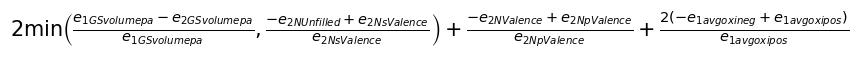

In [63]:
vis_expr(classifier, 'models/test')

In [7]:
### Plot ROC
fpr, tpr, _ = roc_curve(labels_test,predictions)
plt.figure()
plt.plot( fpr, tpr, color="darkorange", 
         label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="k", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

NameError: name 'predictions' is not defined

In [11]:
### Train a single sym learner
SR_classifier = SymbolicClassifier(population_size = 500, 
                                   generations=100,
                                   tournament_size = 10,
                                   init_depth=(1,5),
                                   parsimony_coefficient=0.005,
                                   p_crossover = 0.85,
                                   p_subtree_mutation = 0.01,
                                   p_point_mutation = 0.01,
                                   p_hoist_mutation = 0.1,
                                   const_range=(-10,10),
                                   feature_names=feature_names,
                                   n_jobs=-1, 
                                   verbose=1,
                                   random_state=1,
                                   function_set={'add','sub','mul','div','max','min'}
                                  )

SR_classifier.fit(features_train, labels_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    20.50          3.82292       19         0.547849              N/A     10.88s
   1     9.06          1.60664       19         0.533329              N/A     19.46s
   2    14.69          1.18052       21         0.507781              N/A     21.44s
   3    13.15          1.08945       31         0.497648              N/A     22.73s
   4    12.29         0.947057       13         0.466955              N/A     22.10s
   5    11.73          0.87825       13         0.466955              N/A     21.73s
   6    14.13          0.86876       17         0.458499              N/A     22.16s
   7    12.47         0.872614       13         0.466955              N/A     22.03s
   8    13.14         0.843286       13         0.458499              N/A  

SymbolicClassifier(const_range=(-10, 10),
                   feature_names=Index(['e1_CovalentRadius/e2_CovalentRadius',
       '(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius',
       '(e1_Column+e2_Column)/e1_Column'],
      dtype='object'),
                   function_set={'mul', 'max', 'div', 'min', 'add', 'sub'},
                   generations=100, init_depth=(1, 5), n_jobs=-1,
                   p_crossover=0.85, p_hoist_mutation=0.1,
                   parsimony_coefficient=0.005, population_size=250,
                   random_state=1, tournament_size=50, verbose=1)

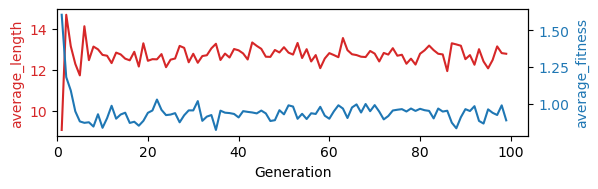

AUC:    	83
Precision: 	82
Recall: 	85
Acc (-):    	87


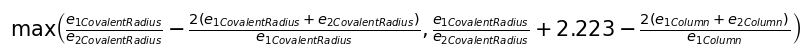

In [12]:
examine_model(SR_classifier)

In [ ]:
#Computing estimated probabilities

estimated_classes = SR_classifier.predict_proba(remainder_negative_features)[:,1]

estimated_classes[:20]